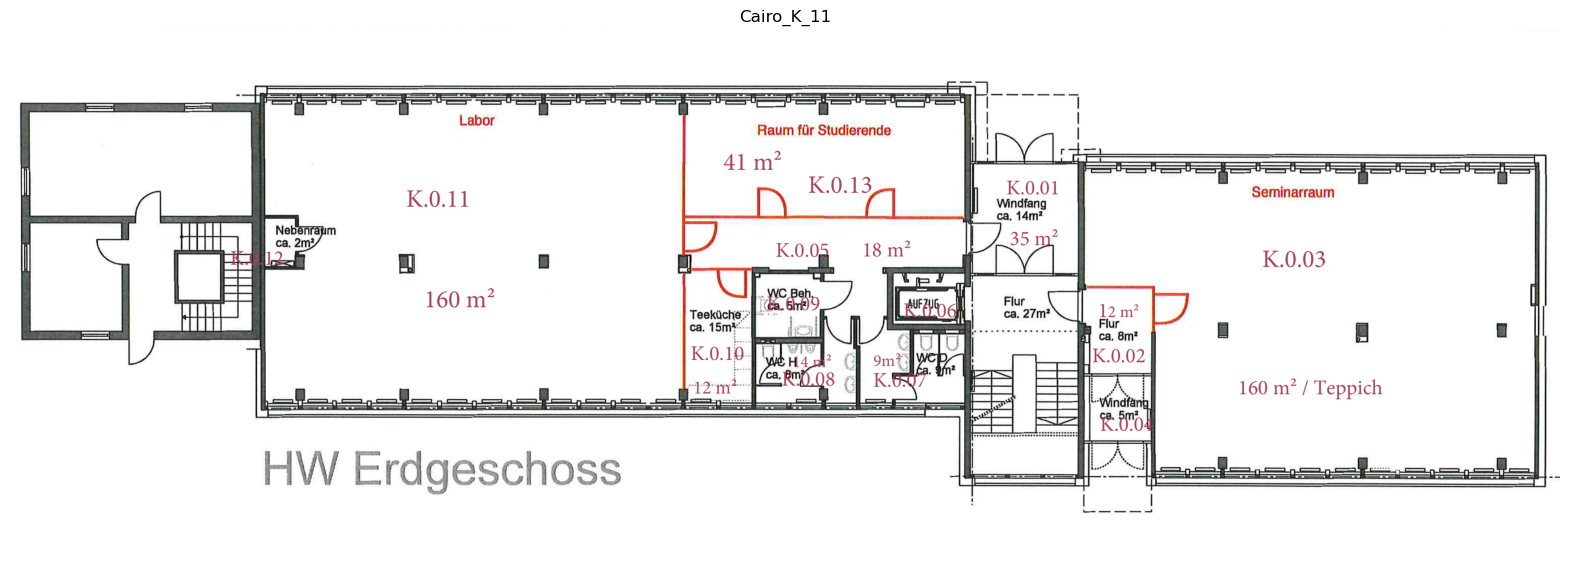

Image shape: (1450, 4120, 3)


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# set your image path (use your cropped, high-DPI PNG)
IMG_PATH = "data/floor_plan_cropped.png"
img = cv2.imread("data/floor_plan_cropped.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.title("Cairo_K_11")
plt.axis("off")
plt.show()

print(f"Image shape: {img.shape}")

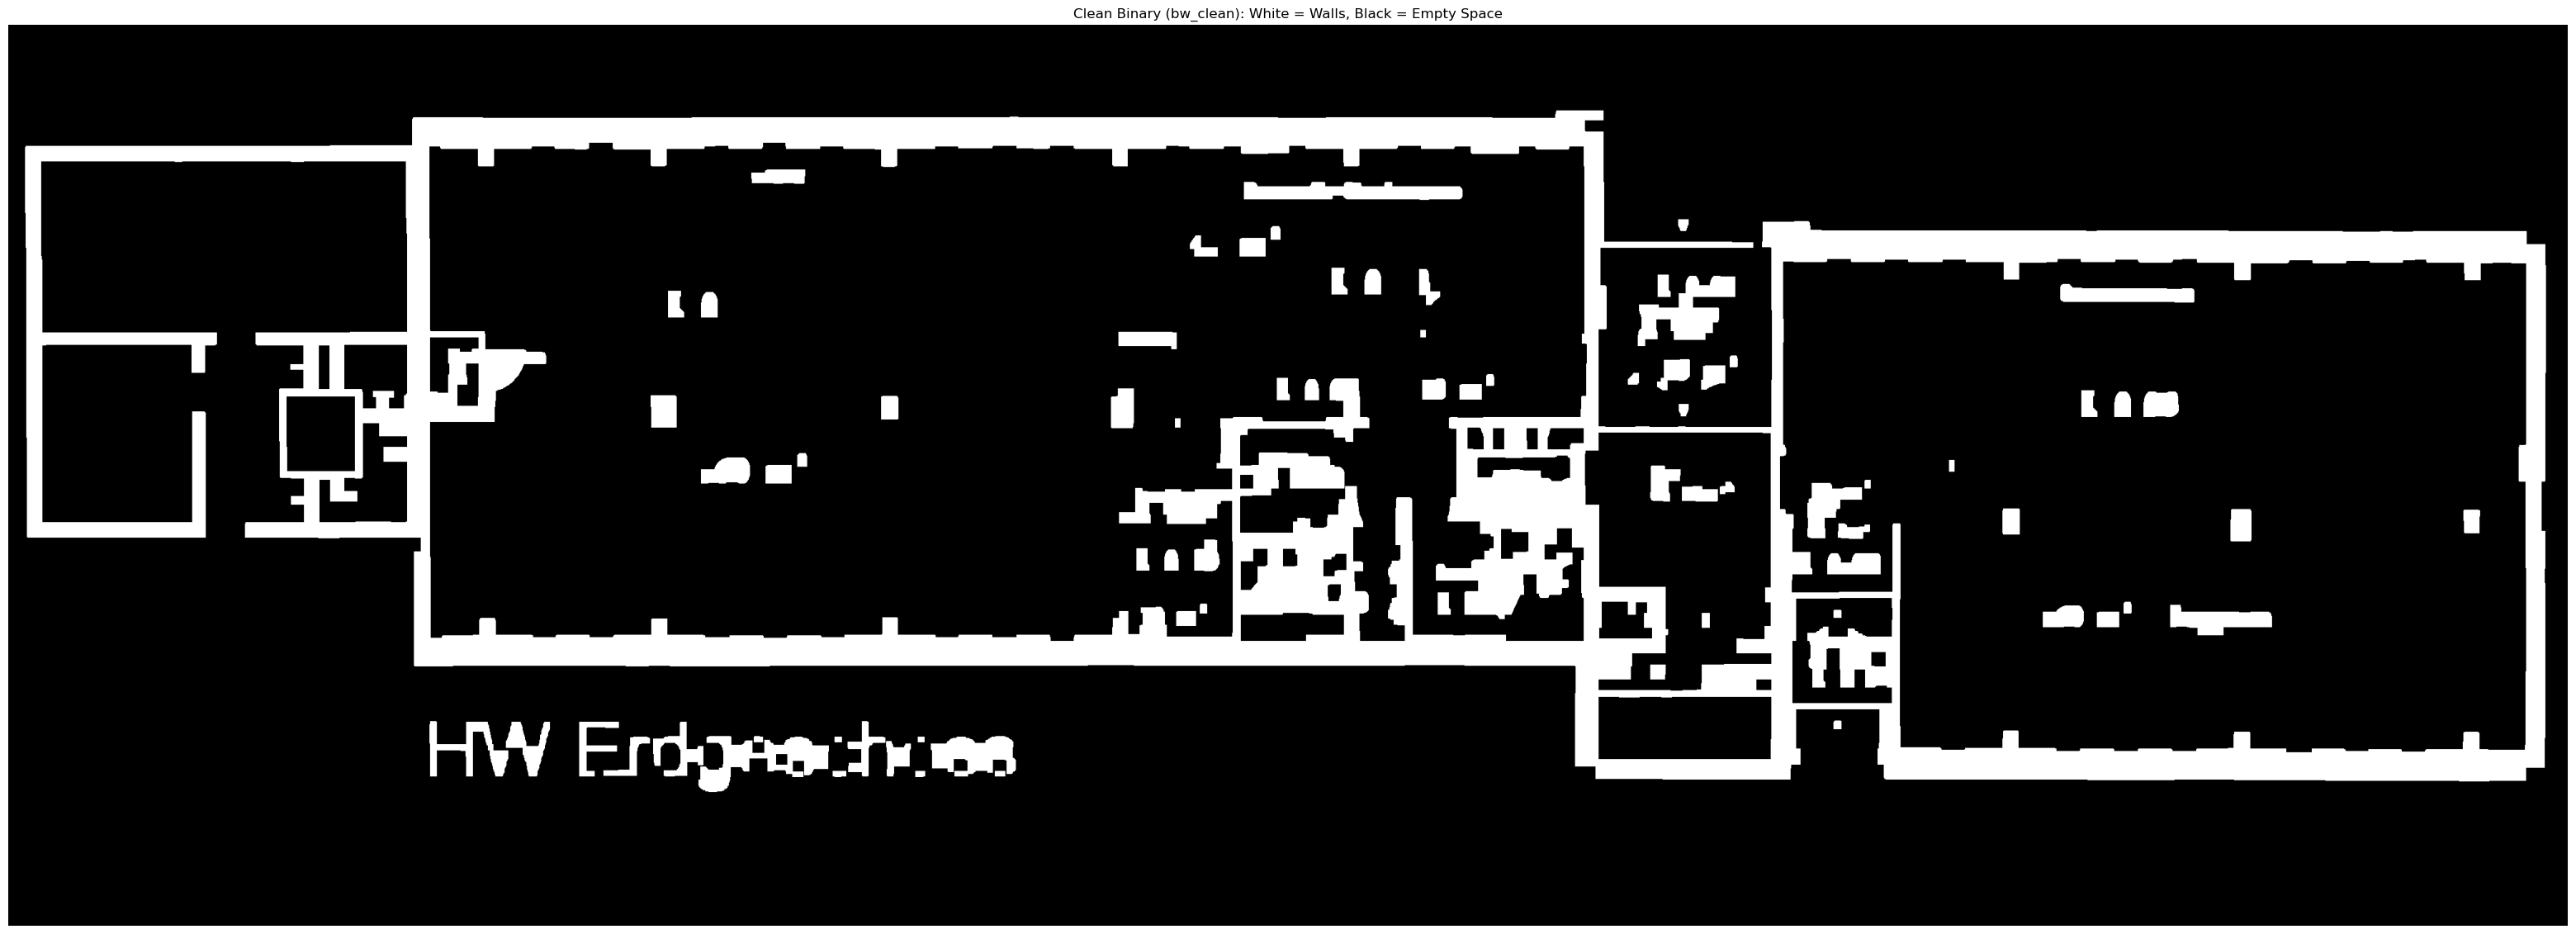

In [6]:
# 1️⃣ Convert to grayscale (you already did this)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# 2️⃣ Apply Otsu's threshold to create black & white image
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3️⃣ Invert if needed (so walls = white)
if np.mean(bw) > 127:
    bw = cv2.bitwise_not(bw)

# 4️⃣ Clean small specks and connect thin gaps in walls
kernel = np.ones((9,9), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# 5️⃣ Visualize the clean binary
plt.figure(figsize=(40,30))
plt.imshow(bw_clean, cmap='gray')
plt.title("Clean Binary (bw_clean): White = Walls, Black = Empty Space")
plt.axis("off")
plt.show()


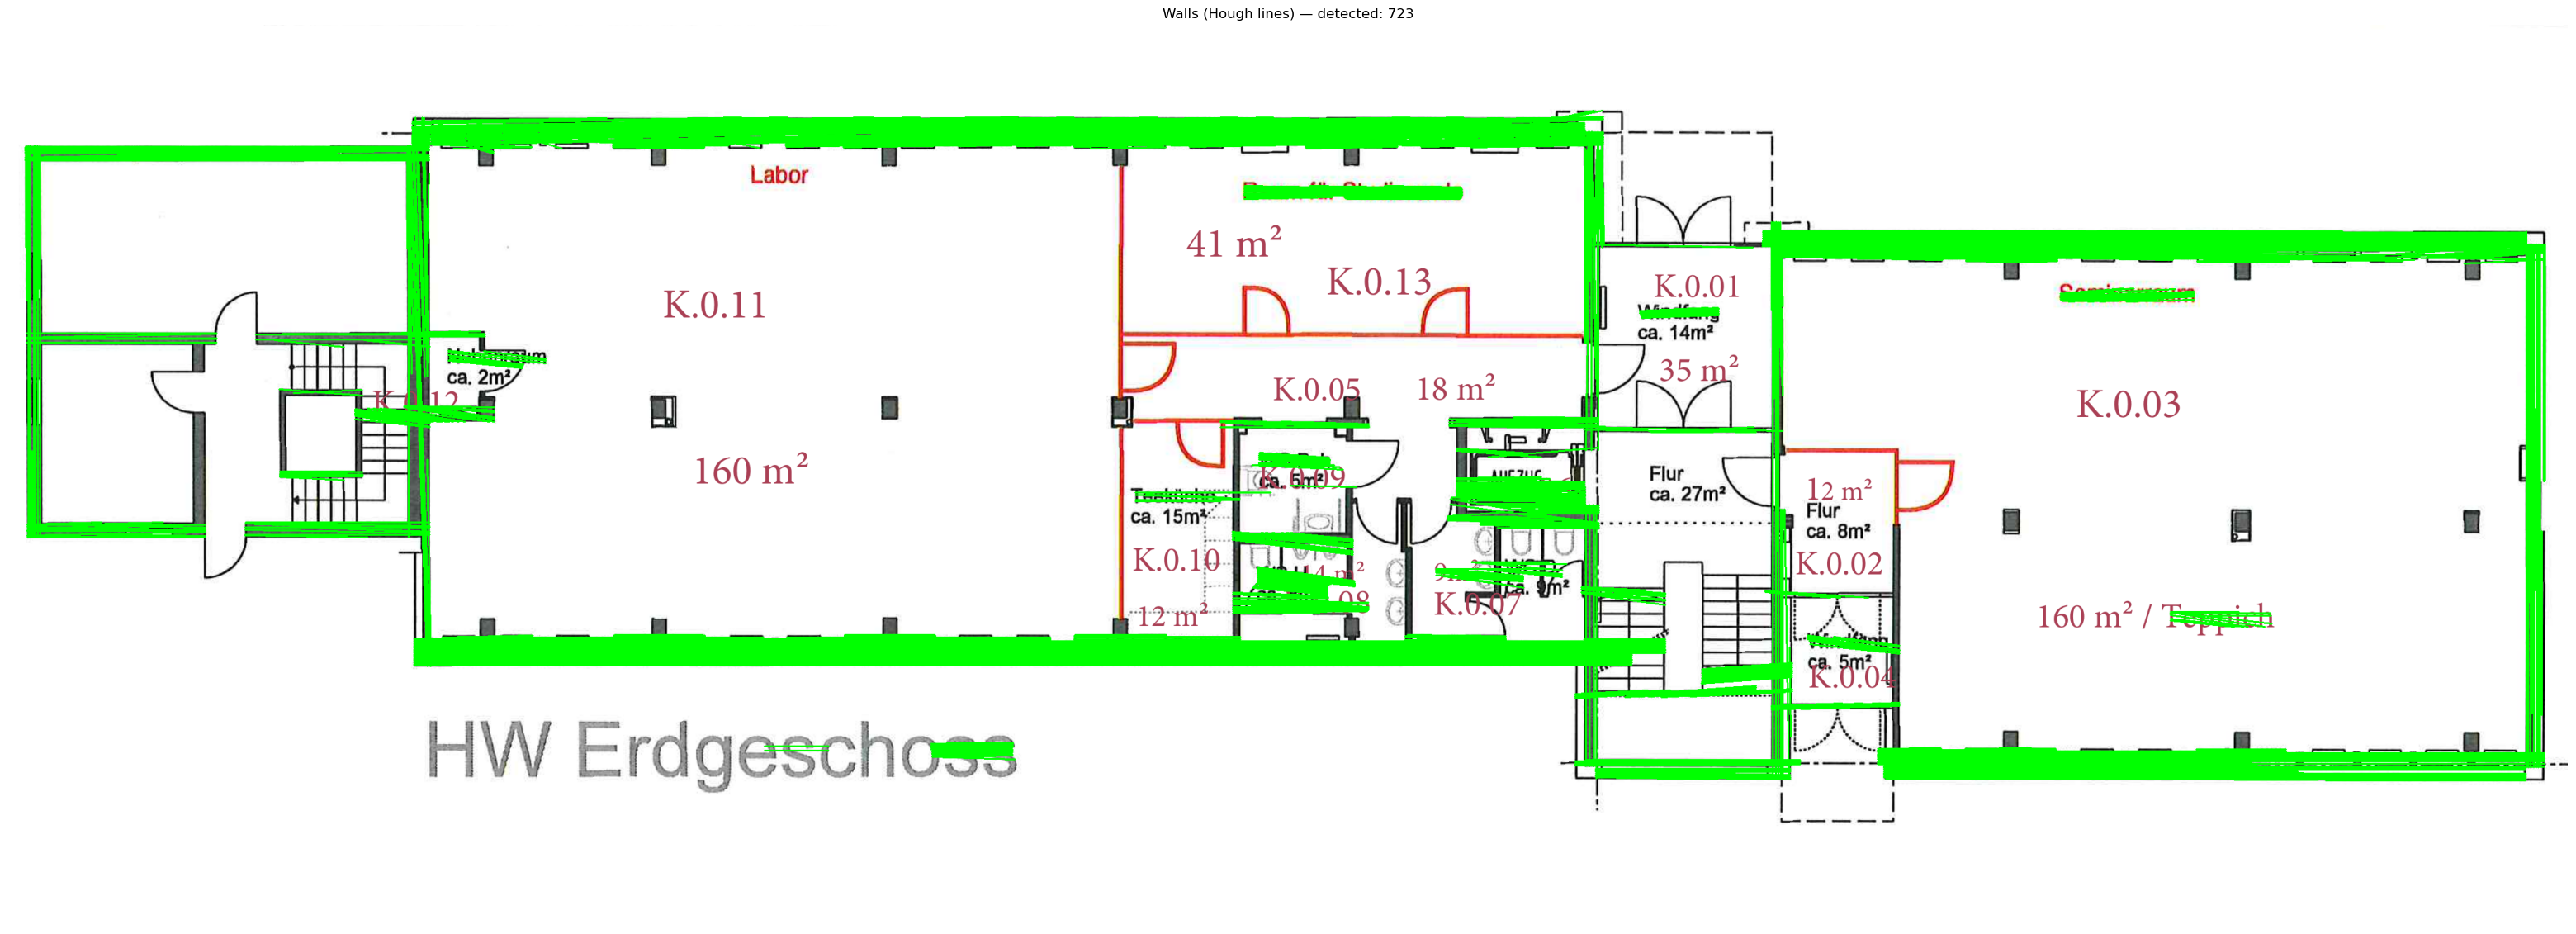

In [7]:
# Hough transform to turn edge pixels into straight line segments (walls)
lines = cv2.HoughLinesP(
    bw_clean,
    rho=2,                         # distance resolution in pixels
    theta=np.pi/180,               # angular resolution in radians (~1 degree)
    threshold=120,                  # votes needed; lower = more lines
    minLineLength=100,              # discard very short segments
    maxLineGap=5                 # connect broken pieces up to this gap
)

# visualize on top of the original image
vis = img_rgb.copy()
if lines is not None:
    for (x1, y1, x2, y2) in lines[:, 0, :]:
        cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(40,30))
plt.imshow(vis)
plt.title(f"Walls (Hough lines) — detected: {0 if lines is None else len(lines)}")
plt.axis("off")
plt.show()


['data/doors/double_door.png', 'data/doors/black_door.png', 'data/doors/red_door.png']


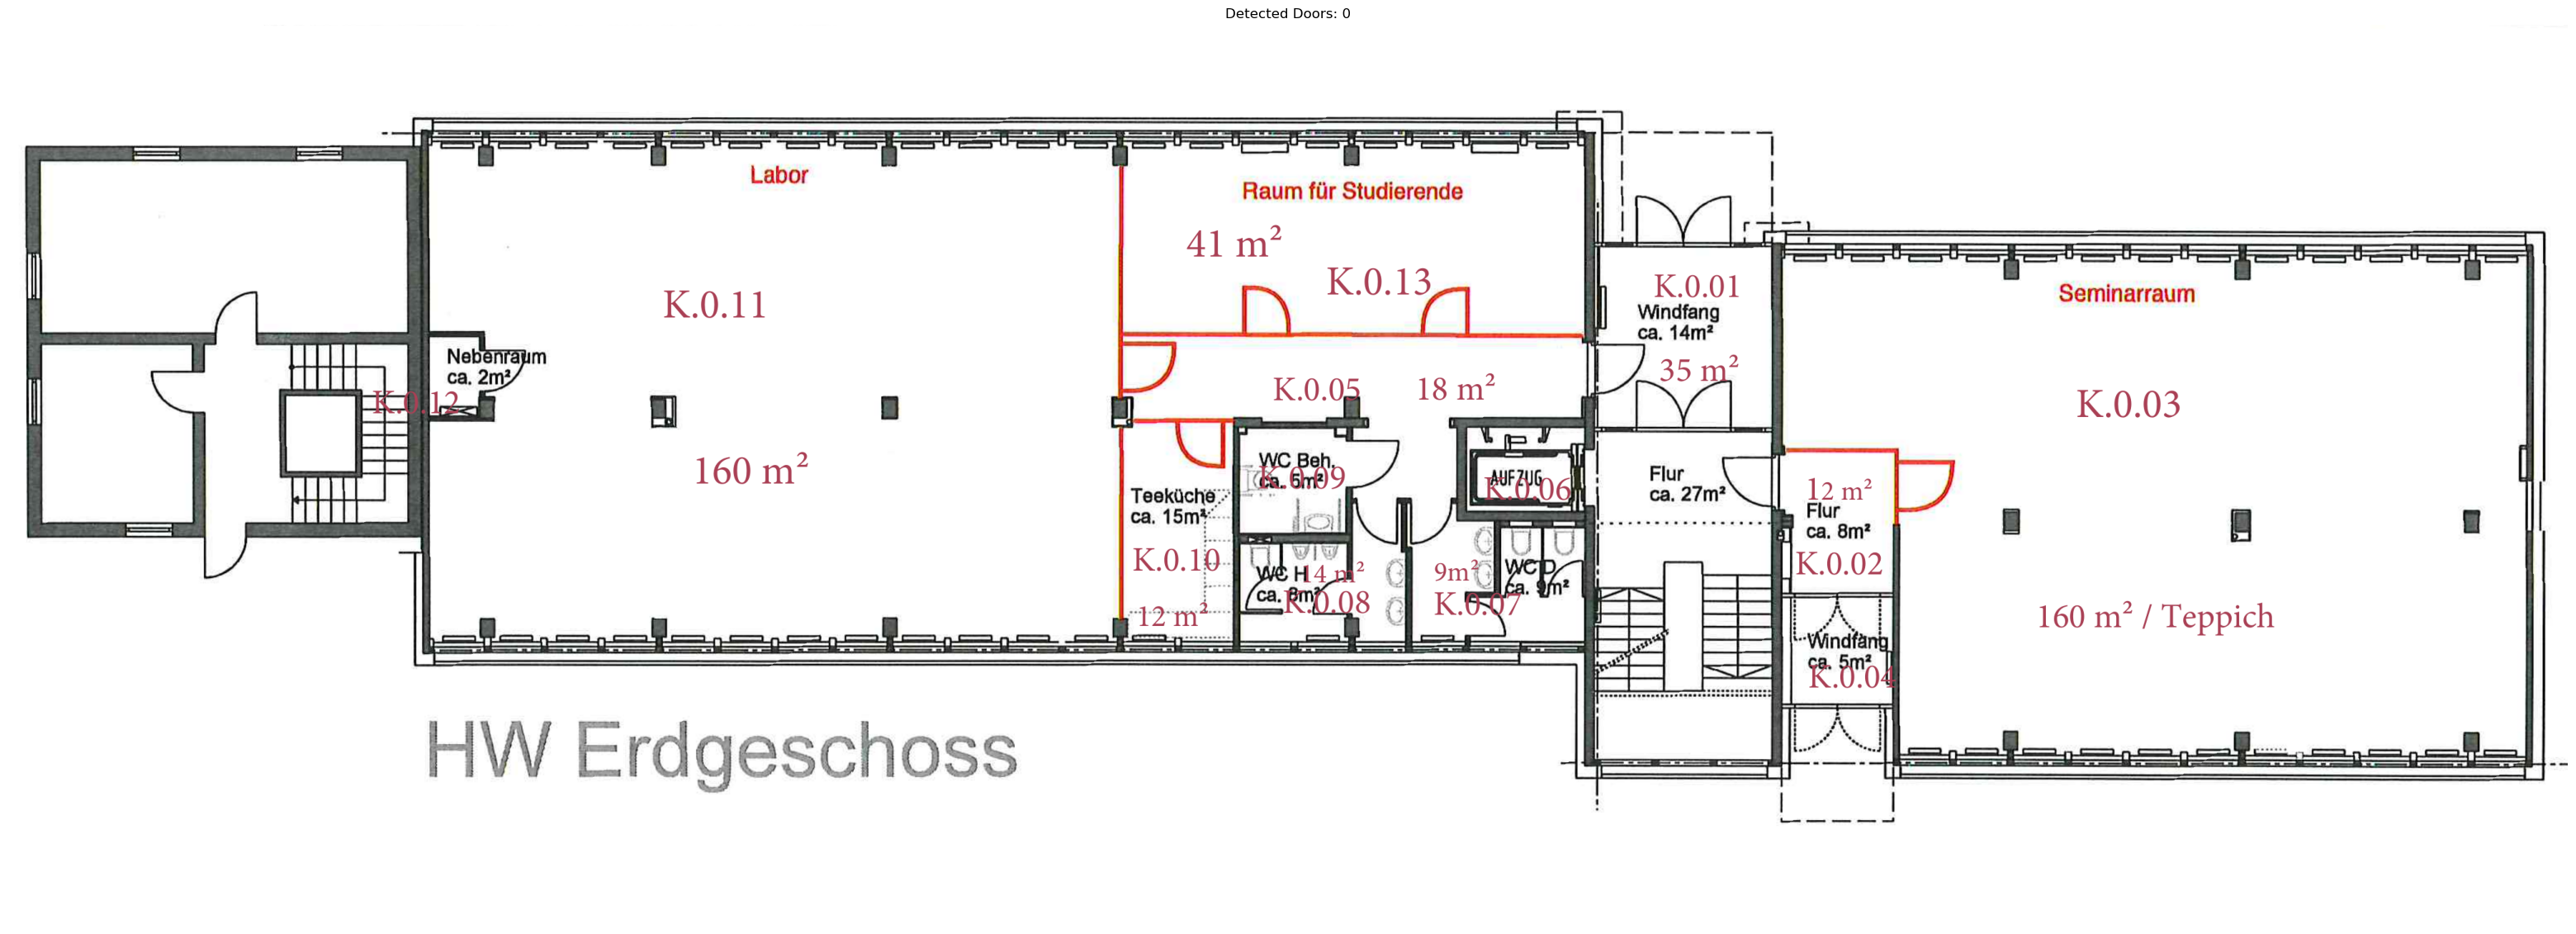

In [12]:
import glob
template_paths = glob.glob("data/doors/*.png")
print(template_paths)

scales = [0.8, 1.0, 1.2]     # door size variation
angles = [0, 90, 180, 270]   # rotations
matches = []

for path in template_paths:
    tmpl_raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # === NEW: Smooth door template before edge detection ===
    tmpl_smooth = cv2.GaussianBlur(tmpl_raw, (9, 9), 0)
    tmpl_edges = cv2.Canny(tmpl_raw, 50, 150)

    for s in scales:
        t_resized = cv2.resize(tmpl_edges, None, fx=s, fy=s, interpolation=cv2.INTER_AREA)
        for a in angles:
            # rotate template
            center = (t_resized.shape[1]//2, t_resized.shape[0]//2)
            M = cv2.getRotationMatrix2D(center, a, 1.0)
            t_rot = cv2.warpAffine(t_resized, M, (t_resized.shape[1], t_resized.shape[0]))

            # template matching on edges
            res = cv2.matchTemplate(bw, t_rot, cv2.TM_CCOEFF_NORMED)
            yy, xx = np.where(res >= 0.6)  # threshold: adjust between 0.6–0.75

            h, w = t_rot.shape[:2]
            for (x, y) in zip(xx, yy):
                matches.append((x, y, w, h, path, a, s, res[y, x]))

# Non-maximum suppression to merge overlapping detections
def nms(detections, iou_thresh=0.5):
    if len(detections) == 0:
        return []
    boxes = np.array([[x, y, x+w, y+h, score] for (x, y, w, h, _, _, _, score) in detections])
    indices = boxes[:,4].argsort()[::-1]
    keep = []
    while len(indices) > 0:
        i = indices[0]
        keep.append(i)
        rest = indices[1:]
        x1 = np.maximum(boxes[i,0], boxes[rest,0])
        y1 = np.maximum(boxes[i,1], boxes[rest,1])
        x2 = np.minimum(boxes[i,2], boxes[rest,2])
        y2 = np.minimum(boxes[i,3], boxes[rest,3])
        inter = np.maximum(0, x2-x1)*np.maximum(0, y2-y1)
        area_i = (boxes[i,2]-boxes[i,0])*(boxes[i,3]-boxes[i,1])
        area_r = (boxes[rest,2]-boxes[rest,0])*(boxes[rest,3]-boxes[rest,1])
        iou = inter / (area_i + area_r - inter + 1e-6)
        indices = rest[iou < iou_thresh]
    return [detections[k] for k in keep]

filtered = nms(matches, iou_thresh=0.35)

# Draw results
vis = img_rgb.copy()
for (x, y, w, h, path, a, s, score) in filtered:
    cv2.rectangle(vis, (x, y), (x+w, y+h), (255, 0, 255), 2)
    label = f"{path.split('/')[-1]} {a}° {s:.1f}x"
    cv2.putText(vis, label, (x, y-4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,255), 1)

plt.figure(figsize=(40, 30))
plt.imshow(vis)
plt.axis("off")
plt.title(f"Detected Doors: {len(filtered)}")
plt.show()